In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)


from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from xgboost import XGBClassifier
import dalex as dx
from yellowbrick.classifier import DiscriminationThreshold

In [4]:
def train_and_evaluate_model(model, X, y, numerical_cols, categorical_cols, n_folds):
    y_pred_probs = np.array([])
    y_pred = np.array([])
    y_true = np.array([])

    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=2)

    for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        num_pipeline = Pipeline(steps=[
            ('impute', SimpleImputer(strategy='median')),
            ('normalization', MinMaxScaler())
        ])
        cat_pipeline = Pipeline(steps=[
            ('impute', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
        ])
        preprocessor = ColumnTransformer(transformers=[
            ('num', num_pipeline, numerical_cols),
            ('cat', cat_pipeline, categorical_cols)
        ])
        model_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        X_train_split, X_test_split = X.iloc[train_idx], X.iloc[test_idx]
        y_train_split, y_test_split = y.iloc[train_idx], y.iloc[test_idx]
        model_pipeline.fit(X_train_split, y_train_split)
        y_pred_prob_fold = model_pipeline.predict_proba(X_test_split)[:, 1]
        y_pred_fold = model_pipeline.predict(X_test_split)
        false_positive_rate, true_positive_rate, _ = roc_curve(y_test_split, y_pred_prob_fold)
        y_pred_probs = np.concatenate([y_pred_probs, y_pred_prob_fold])
        y_pred = np.concatenate([y_pred, y_pred_fold])
        y_true = np.concatenate([y_true, y_test_split])
        print(f"Fold {i}:")
        print(f"ROC AUC score: {roc_auc_score(y_test_split, y_pred_prob_fold)}\n")
    
    num_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='median')),
        ('normalization', MinMaxScaler())
    ])
    cat_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer(transformers=[
        ('num', num_pipeline, numerical_cols),
        ('cat', cat_pipeline, categorical_cols)
    ])
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    model_pipeline.fit(X, y)

    print(f"Total scores:")

    false_positive_rate, true_positive_rate, _ = roc_curve(y_true, y_pred_probs)
    total_roc_auc = roc_auc_score(y_true, y_pred_probs)
    print(f"ROC AUC score: {total_roc_auc}\n")
    return y_true, y_pred, y_pred_probs, false_positive_rate, true_positive_rate, total_roc_auc, model_pipeline

def plot_roc(false_positive_rate, true_positive_rate, total_roc_auc):
    plt.figure(figsize=(6,5))
    plt.plot(false_positive_rate, true_positive_rate, color='blue', lw=2, label=f'ROC (AUC = {total_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion matrix')
    plt.show()

def plot_feature_importances(model, X, y):
    explainer = dx.Explainer(model, X, y)
    importances = explainer.model_parts()
    importances.plot()

def plot_discrimination_threshold(model, X, y):
    visualizer = DiscriminationThreshold(model)
    visualizer.fit(X, y)
    visualizer.show()

# Example

Fold 0:
ROC AUC score: 0.731748726655348

Fold 1:
ROC AUC score: 0.793010752688172

Fold 2:
ROC AUC score: 0.8270609318996416

Fold 3:
ROC AUC score: 0.732078853046595

Fold 4:
ROC AUC score: 0.6747195858498706

Total scores:
ROC AUC score: 0.7376530181511186



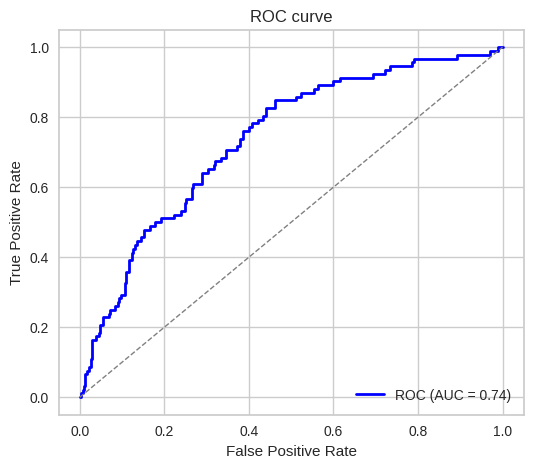

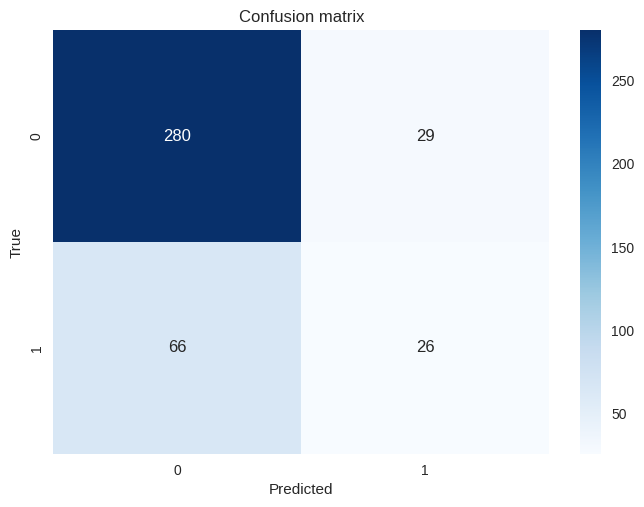

Preparation of a new explainer is initiated

  -> data              : 401 rows 15 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 401 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7dcf8d499d00> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.00306, mean = 0.23, max = 0.904
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.691, mean = -0.00103, max = 0.926
  -> model_info        : package sklearn

A new explainer has been created!


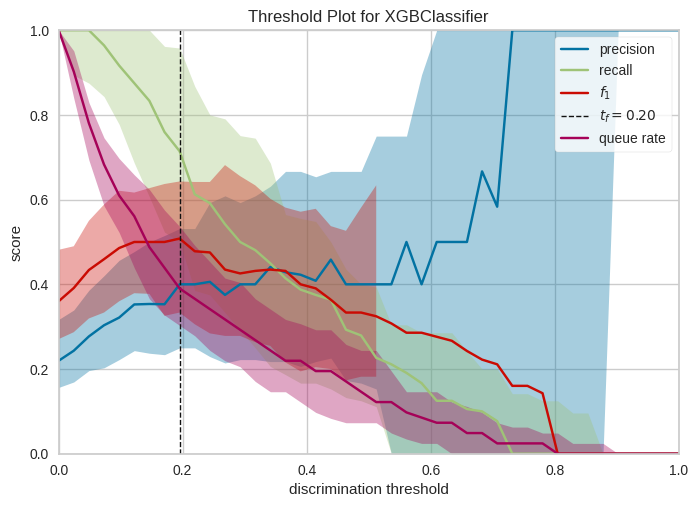

In [ ]:
df = pd.read_csv('../materials/processed_df.csv')
df.head()

numerical_cols = ['wiek', 'PSA', 'PSAdensity', 'MRI vol', 'MRI SIZE']
categorical_cols = ['MRI EPE (naciek poza torebke)', 'MRI Pirads', 'MRI EPE L', 'MRI EPE P', 'MRI SVI (pecherzyki)', 'MRI SVI L', 'MRI SVI P','Bx ISUP Grade P', 'Bx ISUP Grade L', 'Bx ISUP Grade']

X = df[numerical_cols + categorical_cols]
y = df['EPE micro']
hyperparams = {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

untrained_model = XGBClassifier(random_state=2, **hyperparams)

y_true, y_pred, y_pred_probs, false_positive_rate, true_positive_rate, total_roc_auc, trained_model = train_and_evaluate_model(untrained_model, X, y, numerical_cols, categorical_cols, n_folds=5)
plot_roc(false_positive_rate, true_positive_rate, total_roc_auc)
plot_confusion_matrix(y_true, y_pred)
plot_feature_importances(trained_model, X, y)
plot_discrimination_threshold(untrained_model, X, y)